# API Usage Demonstration

This notebook demonstrates the core functionalities of the `CloudPickle.py` wrapper, focusing on:
1. Fetching Bitcoin price data from CoinGecko (native API interaction via wrapper).
2. Serializing and deserializing Python objects (DataFrames and functions) using `cloudpickle` through the wrapper.
3. Performing basic time series analysis (moving average, trend) using utility functions.
4. Visualizing data.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import os

try:
    from CloudPickle_utils import (
        fetch_bitcoin_price_history,
        serialize_object,
        deserialize_object,
        calculate_moving_average,
        simple_trend_analysis,
        plot_price_data
    )
    print("CloudPickle_utils.py loaded successfully.")
except ImportError as e:
    print(f"ImportError: {e}. Make sure CloudPickle_utils.py is in the current directory or your PYTHONPATH.")
    # Fallback if running in an environment where direct import might be tricky initially


CloudPickle_utils.py loaded successfully.


# Data Ingestion: Fetching Bitcoin Price Data

We use `Workspace_bitcoin_price_history` to get data from CoinGecko. This function handles the call to the native API endpoint `/coins/bitcoin/market_chart`.


In [4]:
print("Fetching Bitcoin price data for the last 24 hours (hourly data)...")
btc_data_hourly = fetch_bitcoin_price_history(days=1, currency='usd')

if btc_data_hourly is not None and not btc_data_hourly.empty:
    print("\nSuccessfully fetched hourly Bitcoin data:")
    display(btc_data_hourly.head())
    print(f"\nShape of data: {btc_data_hourly.shape}")
else:
    print("\nFailed to fetch hourly Bitcoin data or no data returned.")


Fetching Bitcoin price data for the last 24 hours (hourly data)...
Fetching Bitcoin data from CoinGecko: days=1, currency=usd
Successfully fetched 287 data points.

Successfully fetched hourly Bitcoin data:


,price
timestamp,
2025-05-15 23:36:25.403,103548.646042
2025-05-15 23:41:38.718,103612.719449
2025-05-15 23:45:26.078,103630.958901
2025-05-15 23:50:41.241,103703.611049
2025-05-15 23:55:53.685,103708.851364



Shape of data: (287, 1)


In [5]:
print("\nFetching Bitcoin price data for the last 7 days (daily data)...")
btc_data_daily = fetch_bitcoin_price_history(days=7, currency='usd')

if btc_data_daily is not None and not btc_data_daily.empty:
    print("\nSuccessfully fetched daily Bitcoin data:")
    display(btc_data_daily.head())
    print(f"\nShape of data: {btc_data_daily.shape}")
else:
    print("\nFailed to fetch daily Bitcoin data or no data returned.")



Fetching Bitcoin price data for the last 7 days (daily data)...
Fetching Bitcoin data from CoinGecko: days=7, currency=usd
Successfully fetched 169 data points.

Successfully fetched daily Bitcoin data:


,price
timestamp,
2025-05-10 00:04:37.665,102974.907551
2025-05-10 01:04:44.992,102888.538003
2025-05-10 02:07:46.492,102993.943862
2025-05-10 03:04:36.887,103150.341515
2025-05-10 04:08:29.682,103193.129672



Shape of data: (169, 1)


# Data Serialization and Deserialization with `cloudpickle`

The wrapper functions `serialize_object` and `deserialize_object` use `cloudpickle` internally.


## Serializing and Deserializing a DataFrame


In [6]:
DF_SERIALIZATION_FILE = 'btc_daily_data_api_demo.pkl'

if btc_data_daily is not None and not btc_data_daily.empty:
    print(f"\nSerializing the daily DataFrame to {DF_SERIALIZATION_FILE}...")
    serialize_object(btc_data_daily, DF_SERIALIZATION_FILE)

    print(f"\nDeserializing the DataFrame from {DF_SERIALIZATION_FILE}...")
    deserialized_btc_data = deserialize_object(DF_SERIALIZATION_FILE)

    if deserialized_btc_data is not None:
        print("\nVerifying deserialized data (first 5 rows):")
        display(deserialized_btc_data.head())
        if btc_data_daily.equals(deserialized_btc_data):
            print("Serialization and deserialization successful: DataFrames are identical.")
        else:
            print("Warning: Deserialized DataFrame differs from original.")
    else:
        print("Deserialization failed.")
    # Clean up the created file
    if os.path.exists(DF_SERIALIZATION_FILE):
        try:
            os.remove(DF_SERIALIZATION_FILE)
            print(f"Cleaned up {DF_SERIALIZATION_FILE}")
        except Exception as e:
            print(f"Could not clean up {DF_SERIALIZATION_FILE}: {e}")
else:
    print("\nSkipping DataFrame serialization demo as daily data was not fetched.")



Serializing the daily DataFrame to btc_daily_data_api_demo.pkl...
Object successfully serialized to btc_daily_data_api_demo.pkl

Deserializing the DataFrame from btc_daily_data_api_demo.pkl...
Object successfully deserialized from btc_daily_data_api_demo.pkl

Verifying deserialized data (first 5 rows):


,price
timestamp,
2025-05-10 00:04:37.665,102974.907551
2025-05-10 01:04:44.992,102888.538003
2025-05-10 02:07:46.492,102993.943862
2025-05-10 03:04:36.887,103150.341515
2025-05-10 04:08:29.682,103193.129672


Serialization and deserialization successful: DataFrames are identical.
Cleaned up btc_daily_data_api_demo.pkl


## Serializing and Deserializing a Function

`cloudpickle` excels at serializing more complex Python objects like functions, including those defined locally or with closures. Here, we'll serialize one of our utility functions.


In [7]:
FUNC_SERIALIZATION_FILE = 'sma_calculator_func_api_demo.pkl'
function_to_serialize = calculate_moving_average # This is the function object itself

print(f"\nSerializing the 'calculate_moving_average' function to {FUNC_SERIALIZATION_FILE}...")
serialize_object(function_to_serialize, FUNC_SERIALIZATION_FILE)

print(f"\nDeserializing the function from {FUNC_SERIALIZATION_FILE}...")
deserialized_func = deserialize_object(FUNC_SERIALIZATION_FILE)

if deserialized_func is not None:
    print(f"Successfully deserialized function: {deserialized_func.__name__}")
    # Test the deserialized function
    if btc_data_daily is not None and not btc_data_daily.empty:
        print("\nApplying the deserialized SMA function to daily data (window=2)...")
        df_processed_by_deserialized_func = deserialized_func(btc_data_daily.copy(), 2) # window_size = 2
        if df_processed_by_deserialized_func is not None:
            display(df_processed_by_deserialized_func.head())
        else:
            print("Deserialized function did not return a DataFrame.")
    else:
        print("\nSkipping test of deserialized function as daily data was not fetched.")
    # Clean up
    if os.path.exists(FUNC_SERIALIZATION_FILE):
        try:
            os.remove(FUNC_SERIALIZATION_FILE)
            print(f"Cleaned up {FUNC_SERIALIZATION_FILE}")
        except Exception as e:
            print(f"Could not clean up {FUNC_SERIALIZATION_FILE}: {e}")
else:
    print(f"Failed to deserialize the function from {FUNC_SERIALIZATION_FILE}.")



Serializing the 'calculate_moving_average' function to sma_calculator_func_api_demo.pkl...
Object successfully serialized to sma_calculator_func_api_demo.pkl

Deserializing the function from sma_calculator_func_api_demo.pkl...
Object successfully deserialized from sma_calculator_func_api_demo.pkl
Successfully deserialized function: calculate_moving_average

Applying the deserialized SMA function to daily data (window=2)...


,price,sma_2
timestamp,,
2025-05-10 00:04:37.665,102974.907551,102974.907551
2025-05-10 01:04:44.992,102888.538003,102931.722777
2025-05-10 02:07:46.492,102993.943862,102941.240933
2025-05-10 03:04:36.887,103150.341515,103072.142688
2025-05-10 04:08:29.682,103193.129672,103171.735593


Cleaned up sma_calculator_func_api_demo.pkl


# Basic Time Series Analysis Functions


## Calculating Moving Average


In [8]:
btc_data_with_sma = None 
if btc_data_daily is not None and not btc_data_daily.empty:
    window = 3 # 3-day moving average for daily data
    print(f"\nCalculating {window}-day Simple Moving Average (SMA) for daily data...")
    btc_data_with_sma = calculate_moving_average(btc_data_daily.copy(), window_size=window)
    if btc_data_with_sma is not None:
        display(btc_data_with_sma.head())
    else:
        print("SMA calculation resulted in None.")
else:
    print("\nSkipping SMA calculation as daily data was not fetched.")



Calculating 3-day Simple Moving Average (SMA) for daily data...


,price,sma_3
timestamp,,
2025-05-10 00:04:37.665,102974.907551,102974.907551
2025-05-10 01:04:44.992,102888.538003,102931.722777
2025-05-10 02:07:46.492,102993.943862,102952.463139
2025-05-10 03:04:36.887,103150.341515,103010.941127
2025-05-10 04:08:29.682,103193.129672,103112.471683


## Simple Trend Analysis


In [9]:
if btc_data_daily is not None and not btc_data_daily.empty:
    print("\nPerforming simple trend analysis on daily data...")
    trend = simple_trend_analysis(btc_data_daily)
    print(trend)
else:
    print("\nSkipping trend analysis as daily data was not fetched.")



Performing simple trend analysis on daily data...
Simple Trend: Uptrend (Change: 0.68%)


# Plotting Data



Plotting daily Bitcoin price and 3-day SMA...
Plot successfully saved to btc_plot_20250516_233404.png
Plot saved as btc_plot_20250516_233404.png


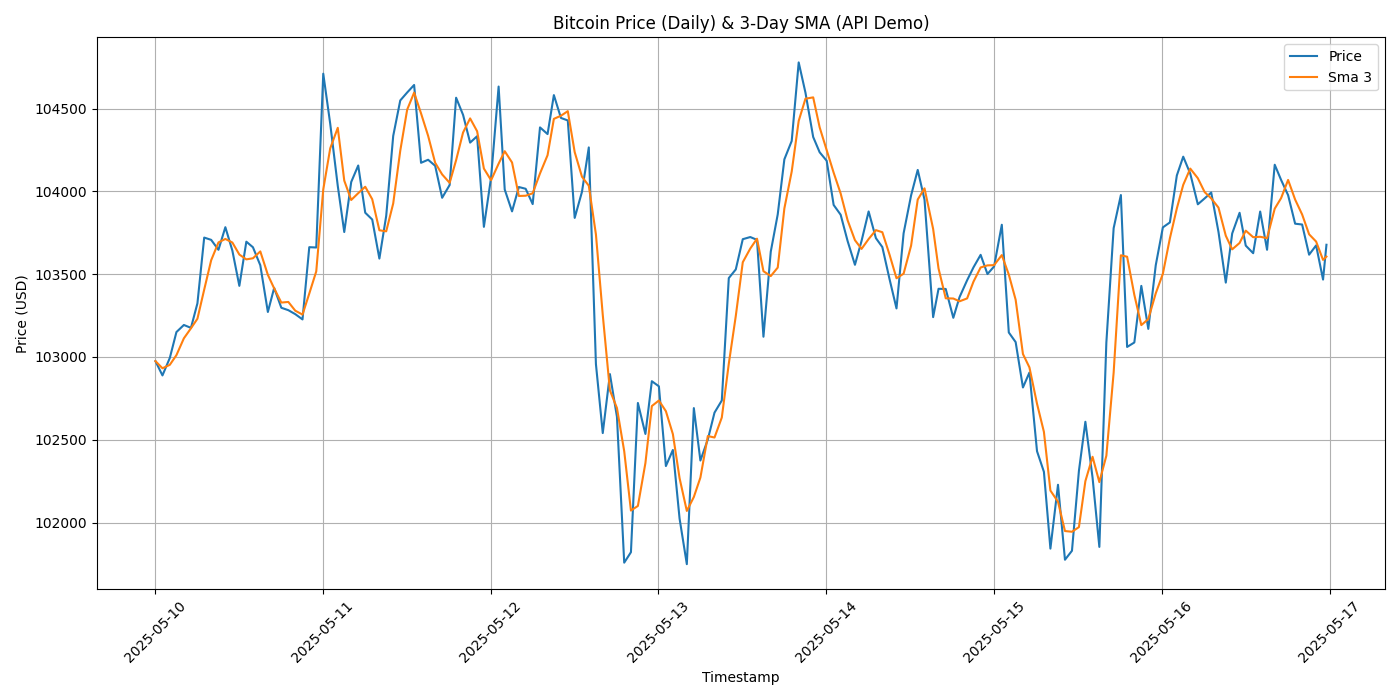

Cleaned up btc_plot_20250516_233404.png


In [10]:
plot_filename = None # Initialize
if btc_data_with_sma is not None and not btc_data_with_sma.empty:
    print("\nPlotting daily Bitcoin price and 3-day SMA...")
    plot_filename = plot_price_data(btc_data_with_sma, 
                                    title="Bitcoin Price (Daily) & 3-Day SMA (API Demo)",
                                    columns_to_plot=['price', f'sma_3']) # Specify columns
elif btc_data_daily is not None and not btc_data_daily.empty:
    print("\nPlotting daily Bitcoin price (SMA not calculated or available)...")
    plot_filename = plot_price_data(btc_data_daily, title="Bitcoin Price (Daily) - API Demo")
else:
    print("\nSkipping plotting as no data was available.")

if plot_filename:
    print(f"Plot saved as {plot_filename}")
    display(Image(filename=plot_filename))
    # Clean up the plot file
    if os.path.exists(plot_filename):
        try:
            os.remove(plot_filename)
            print(f"Cleaned up {plot_filename}")
        except Exception as e:
            print(f"Could not clean up {plot_filename}: {e}")
elif btc_data_with_sma is not None or btc_data_daily is not None: # Only print if we attempted to plot
     print("Plotting failed or DataFrame was empty.")


# Advanced `cloudpickle` Examples

Let’s explore more patterns that **`pickle`** can’t handle but **`cloudpickle`** makes trivial:

1. **Serializing a dynamically created class**  
2. **Serializing `functools.partial` functions**  
3. **Serializing generator functions & objects**  
4. **Serializing instances with methods/closures**  


In [11]:
import cloudpickle
import pickle
from functools import partial

# 1) Dynamically created class
MyClass = type('MyClass', (), {'__init__': lambda self, x: setattr(self, 'x', x),
                                'double': lambda self: self.x * 2})

# pickle will fail on this
try:
    pickle.dumps(MyClass)
except Exception as e:
    print("✔ pickle failed on dynamic class:", e)

# cloudpickle handles it
cls_ser = cloudpickle.dumps(MyClass)
LoadedClass = cloudpickle.loads(cls_ser)
inst = LoadedClass(10)
print("✔ cloudpickle dynamic class result:", inst.double())

# 2) functools.partial
def add(a, b, c): return a + b + c
add5 = partial(add, 2, 3)

try:
    pickle.dumps(add5)
except Exception as e:
    print("✔ pickle failed on partial:", e)

p_ser = cloudpickle.dumps(add5)
p_loaded = cloudpickle.loads(p_ser)
print("✔ cloudpickle partial result:", p_loaded(4))  # 2+3+4 = 9


✔ cloudpickle dynamic class result: 20
✔ cloudpickle partial result: 9


In [13]:
import pickle, cloudpickle

def countdown(n):
    while n > 0:
        yield n
        n -= 1

# pickle fails on the function definition itself
try:
    pickle.dumps(countdown)
except Exception as e:
    print("✔ pickle failed on generator function with pickle:", e)

# cloudpickle can serialize the generator function
gen_fn_ser = cloudpickle.dumps(countdown)
loaded_countdown = cloudpickle.loads(gen_fn_ser)

# Using the loaded function to create a new generator instance:
print("✔ cloudpickle – new countdown from loaded function:", list(loaded_countdown(3)))


# 2) Serializing the *data* produced by a generator instance:
gen_inst = countdown(5)
data = list(gen_inst)  # collect output
data_ser = cloudpickle.dumps(data)
loaded_data = cloudpickle.loads(data_ser)
print("✔ serialized generator output list:", loaded_data)


✔ cloudpickle – new countdown from loaded function: [3, 2, 1]
✔ serialized generator output list: [5, 4, 3, 2, 1]


In [14]:
# 4) Instance capturing a closure + method
def make_accumulator():
    total = 0
    def acc(x):
        nonlocal total
        total += x
        return total
    class AccUser:
        def __init__(self): self.acc = acc
        def add_and_get(self, y): return self.acc(y)
    return AccUser()

user = make_accumulator()

# pickle fails on this nested closure + class
try:
    pickle.dumps(user)
except Exception as e:
    print("✔ pickle failed on instance with closure:", e)

user_ser = cloudpickle.dumps(user)
user_loaded = cloudpickle.loads(user_ser)

print("✔ cloudpickle accumulator sequence:", [user_loaded.add_and_get(i) for i in (1,2,3)])


✔ pickle failed on instance with closure: Can't pickle local object 'make_accumulator.<locals>.AccUser'
✔ cloudpickle accumulator sequence: [1, 3, 6]


This notebook demonstrated the core functionalities of the `CloudPickle_utils.py` wrapper, covering data fetching, serialization/deserialization of data and functions (via `cloudpickle`), basic analysis, and plotting.
